In [5]:
import torch
from torch import no_grad
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss
)
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
import time

import numpy as np
import matplotlib.pyplot as plt

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [7]:
torch.manual_seed(42)
batch_size = 16

# Train DataLoader
data_root = "./music/"

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
train_dataset = custom_dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))

# Test DataLoader
data_root = "./music_test/" 

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
test_dataset = custom_dataset
test_loader = DataLoader(test_dataset, shuffle=False)

print("Number of test samples:", len(test_dataset))

Number of training samples: 160
Number of test samples: 40


In [8]:
def create_qnn():
    feature_map = ZZFeatureMap(8)
    ansatz = RealAmplitudes(8, reps=1)
    qc = QuantumCircuit(8)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    qc.draw(output="mpl", style="clifford")

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn = create_qnn()

In [9]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.conv3 = Conv2d(16, 64, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(102400, 64)
        self.fc2 = Linear(64, 8)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = self.qnn(x)  # apply QNN 
        x= self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [10]:
model = CNN() # Model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer 
loss_func = CrossEntropyLoss() # Loss Functions
epochs = 50  # Set number of epochs
loss_list = []  # Store loss history
accuracy_list = []

model.train()  # Set model to training mode

start_time = time.time()

for epoch in range(epochs):
    y_true = []
    y_pred_probs = []
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(loss)
        probabilities = F.softmax(output, dim=1)
        y_true.extend(target.tolist())
        y_pred_probs.extend(probabilities.tolist())
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    y_pred_probs = torch.tensor(y_pred_probs)
    y_pred = torch.argmax(y_pred_probs, dim=1)
    accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
    accuracy_list.append(accuracy.item())
    print("Accuracy:", accuracy.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    
end_time = time.time()  # Record end time
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

tensor(0.6642, grad_fn=<NllLossBackward0>)
tensor(0.7537, grad_fn=<NllLossBackward0>)
tensor(0.8366, grad_fn=<NllLossBackward0>)
tensor(0.8800, grad_fn=<NllLossBackward0>)
tensor(0.6646, grad_fn=<NllLossBackward0>)
tensor(0.7923, grad_fn=<NllLossBackward0>)
tensor(0.7904, grad_fn=<NllLossBackward0>)
tensor(0.8752, grad_fn=<NllLossBackward0>)
tensor(0.4978, grad_fn=<NllLossBackward0>)
tensor(0.7465, grad_fn=<NllLossBackward0>)
Accuracy: 0.5
Training [2%]	Loss: 0.7501
tensor(0.5817, grad_fn=<NllLossBackward0>)
tensor(0.8274, grad_fn=<NllLossBackward0>)
tensor(0.7043, grad_fn=<NllLossBackward0>)
tensor(0.5827, grad_fn=<NllLossBackward0>)
tensor(0.8225, grad_fn=<NllLossBackward0>)
tensor(0.7028, grad_fn=<NllLossBackward0>)
tensor(0.9382, grad_fn=<NllLossBackward0>)
tensor(0.7804, grad_fn=<NllLossBackward0>)
tensor(0.7791, grad_fn=<NllLossBackward0>)
tensor(0.7009, grad_fn=<NllLossBackward0>)
Accuracy: 0.5
Training [4%]	Loss: 0.7420
tensor(0.7764, grad_fn=<NllLossBackward0>)
tensor(0.6999, 

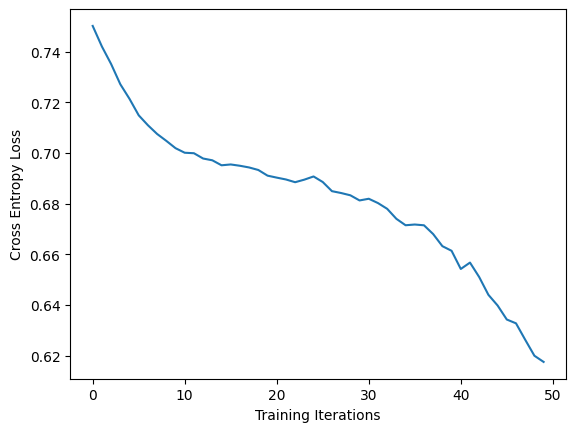

In [11]:
plt.plot(loss_list)
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

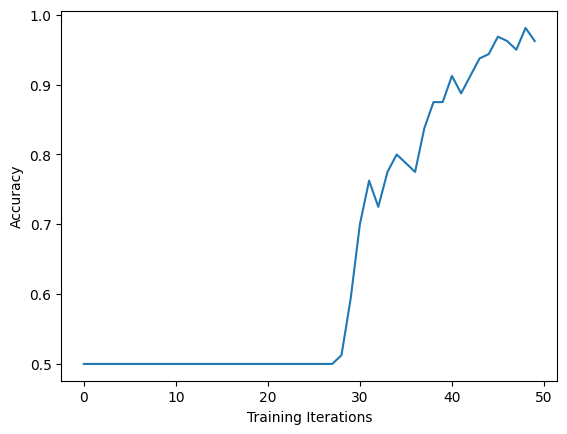

In [12]:
plt.plot(accuracy_list)
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy")
plt.show()

In [13]:
PATH = 'models/music_cnn_quantum.pt'
torch.save(model.state_dict(), PATH)

In [14]:
import torch
PATH = 'models/music_cnn_quantum.pt'
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
from torchmetrics.classification import Accuracy, ConfusionMatrix, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryHingeLoss
model.eval()

CNN(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=102400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [16]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.875
Cross-Entropy Loss: 0.6271018981933594
Confusion Matrix:
[[16, 4], [1, 19]]
F1 Score: 0.8837209343910217
Binary Precision: 0.8260869383811951
Binary Recall: 0.949999988079071


In [17]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in train_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.981249988079071
Cross-Entropy Loss: 0.6087839007377625
Confusion Matrix:
[[80, 0], [3, 77]]
F1 Score: 0.9808917045593262
Binary Precision: 1.0
Binary Recall: 0.9624999761581421


In [18]:
print(loss_list)

[0.7501285642385482, 0.7420000195503235, 0.7350989401340484, 0.7271121978759766, 0.7213417291641235, 0.7148424565792084, 0.7109243929386139, 0.707480525970459, 0.7047552287578582, 0.7018734633922576, 0.7000696301460266, 0.6998764932155609, 0.6977862596511841, 0.6970855712890625, 0.6951175272464752, 0.6954424202442169, 0.6949280977249146, 0.6942545235157013, 0.6932586848735809, 0.6910274744033813, 0.6902457714080811, 0.6895155429840087, 0.6884365737438202, 0.6894496858119965, 0.6907045125961304, 0.6885098099708558, 0.6849005162715912, 0.684163224697113, 0.6832688450813293, 0.68123939037323, 0.681904411315918, 0.6802009999752044, 0.6779336750507354, 0.6739838182926178, 0.6714484572410584, 0.6717334806919097, 0.671429979801178, 0.6679560244083405, 0.6631919622421265, 0.6613588392734527, 0.6541881382465362, 0.65670725107193, 0.6510005593299866, 0.6439887702465057, 0.6397746980190278, 0.6342331767082214, 0.6327316999435425, 0.6262505888938904, 0.6199368834495544, 0.6174967527389527]


In [19]:
print(accuracy_list)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.512499988079071, 0.59375, 0.699999988079071, 0.762499988079071, 0.7250000238418579, 0.7749999761581421, 0.800000011920929, 0.7875000238418579, 0.7749999761581421, 0.8374999761581421, 0.875, 0.875, 0.9125000238418579, 0.887499988079071, 0.9125000238418579, 0.9375, 0.9437500238418579, 0.96875, 0.9624999761581421, 0.949999988079071, 0.981249988079071, 0.9624999761581421]


In [20]:
print(y_pred_probs)

tensor([[0.4649, 0.5351],
        [0.5508, 0.4492],
        [0.4663, 0.5337],
        [0.4646, 0.5354],
        [0.4651, 0.5349],
        [0.4644, 0.5356],
        [0.5251, 0.4749],
        [0.5512, 0.4488],
        [0.5607, 0.4393],
        [0.5501, 0.4499],
        [0.5598, 0.4402],
        [0.5634, 0.4366],
        [0.5534, 0.4466],
        [0.4824, 0.5176],
        [0.4671, 0.5329],
        [0.5630, 0.4370],
        [0.4651, 0.5349],
        [0.4649, 0.5351],
        [0.4653, 0.5347],
        [0.5252, 0.4748],
        [0.5470, 0.4530],
        [0.4649, 0.5351],
        [0.5642, 0.4358],
        [0.4647, 0.5353],
        [0.4649, 0.5351],
        [0.4648, 0.5352],
        [0.4676, 0.5324],
        [0.4654, 0.5346],
        [0.5560, 0.4440],
        [0.5637, 0.4363],
        [0.5637, 0.4363],
        [0.5272, 0.4728],
        [0.4647, 0.5353],
        [0.4652, 0.5348],
        [0.4647, 0.5353],
        [0.4662, 0.5338],
        [0.5639, 0.4361],
        [0.5641, 0.4359],
        [0.5